# Classification - Workshop

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

## Exercise 1: Classify AGN objects

AGN classification , BPT , https://ned.ipac.caltech.edu/level5/Glossary/Essay_bpt.html

### Loading and setting up the data

In [2]:
# CREATING DATA STRUCTURE

# > Loading the emission line data and classifications from Stampoulis+19:

PATH_Stampoulis_data = "data/Stampoulis+19_Table_2.csv"

data = np.genfromtxt(PATH_Stampoulis_data, delimiter=",")
# The data file is organized in 138799 lines (i.e. different objects), and 12 columns

# To check file dimensions:
# print(data.shape)

ID               = data[:,0]  # object ID
NII_diagnostic   = data[:,3]  # log10 ( NII_6584  / H_alpha )
SII_diagnostic   = data[:,4]  # log10 ( SII_6717  / H_alpha )
OI_diagnostic    = data[:,5]  # log10 ( OI        / H_alpha )
OIII_diagnostic  = data[:,6]  # log10 ( OIII_5007 / H_beta )

labels = np.genfromtxt(PATH_Stampoulis_data, delimiter=',', usecols=-1, dtype=str)
# reading labels from last last
# Activity class labelling scheme:
#   0 <-> SFG (Star Forming Galaxy)
#   1 <-> SEY (Seyfert)
#   2 <-> LIN (LINER)
#   3 <-> COM (Composite)

# Dictionary containg class name and associated label:
from collections import OrderedDict
classes = OrderedDict()
classes["SFG"] = 0
classes["SEY"] = 1
classes["LIN"] = 2
classes["COM"] = 3

labels = [int(float(label)) for label in labels]
# converting labels from strings to integers

# > Organizing data in an analysis-ready fashion:
X = np.stack((OIII_diagnostic,NII_diagnostic,SII_diagnostic,OI_diagnostic),axis=-1)
y = labels

In [3]:
# SPLITTING SAMPLE IN TRAINING, VALIDATION, AND TEST

# Fractions of total sample to be re-distributed into training, validation, and test
train_frac = 0.80
valid_frac = 0.10
test_frac  = 0.10

(X_train, X_remain), (y_train, y_remain) = split_samples(X, y, [train_frac, (valid_frac+test_frac)], random_state=0)
# isolating first the training set ...

(X_valid, X_test), (y_valid, y_test)  = split_samples(X_remain, y_remain, [test_frac, valid_frac], random_state=0)
# ... and now repeting to split validation and training sets

# Dictionaries containg the percentage of each class, for each type of set:
demographics_train = {}
demographics_valid = {}
demographics_test  = {}

# Filling demographics dictionaries:
for class_name, class_label_int in classes.items():
    demographics_train[class_name] = len(y_train[y_train == class_label_int])
    demographics_valid[class_name] = len(y_valid[y_valid == class_label_int])
    demographics_test[class_name]  = len(y_test[y_test == class_label_int])
    # number of objects with label 'classs_label_int'

print("Sample Summary")
print("________________________________")
print("Total objects    | %-5s" % len(X))
print("-----------------|--------------")
print(" '-> Training    | %-5s" % len(X_train))
print("                 | " + str(X_train.shape))
for class_name, class_label_int in classes.items():
    print("      '-> %-5s  | %-5s (%-.1f%%)" % (class_name, demographics_train[class_name], (demographics_train[class_name]/len(X_train)*100.)))  
print("-----------------|--------------")
print(" '-> Validation  | %-5s" % len(X_valid))
print("                 | " + str(X_valid.shape))
for class_name, class_label_int in classes.items():
    print("      '-> %-5s  | %-5s (%-.1f%%)" % (class_name, demographics_valid[class_name], (demographics_valid[class_name]/len(X_valid)*100.)))  
print("-----------------|--------------")
print(" '-> Test        | %-5s" % len(X_test))
print("                 | " + str(X_test.shape))
for class_name, class_label_int in classes.items():
    print("      '-> %-5s  | %-5s (%-.1f%%)" % (class_name, demographics_test[class_name], (demographics_test[class_name]/len(X_test)*100.)))  

Sample Summary
________________________________
Total objects    | 130799
-----------------|--------------
 '-> Training    | 104639
                 | (104639, 4)
      '-> SFG    | 86164 (82.3%)
      '-> SEY    | 4249  (4.1%)
      '-> LIN    | 1597  (1.5%)
      '-> COM    | 12629 (12.1%)
-----------------|--------------
 '-> Validation  | 13080
                 | (13080, 4)
      '-> SFG    | 10823 (82.7%)
      '-> SEY    | 579   (4.4%)
      '-> LIN    | 203   (1.6%)
      '-> COM    | 1475  (11.3%)
-----------------|--------------
 '-> Test        | 13080
                 | (13080, 4)
      '-> SFG    | 10820 (82.7%)
      '-> SEY    | 495   (3.8%)
      '-> LIN    | 204   (1.6%)
      '-> COM    | 1561  (11.9%)


### Visualizing the data
Essentially reproducing Figure 5 in Stampoulis+19

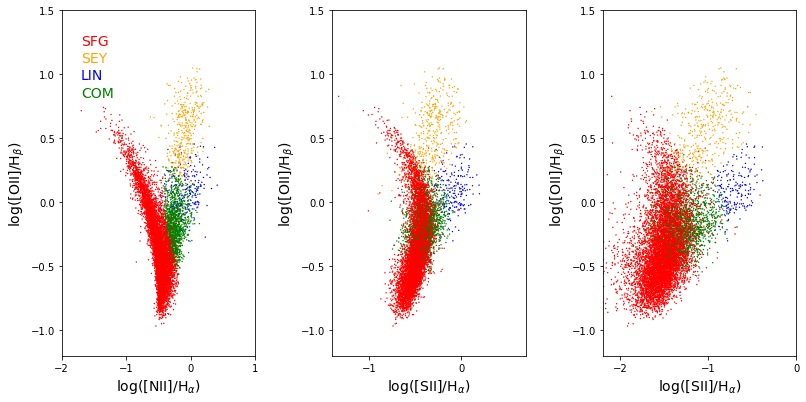

In [4]:
import matplotlib as mpl

# Limit scatter plots (not histograms) in showing a maximum of <N_plot> objects:
N_plot = 10000
# for full sample size, use: N_plot = len(X)

# Creating a colormap where:
#   red    <-> SFG
#   yellow <-> SEY
#   blue   <-> LIN
#   green  <-> COM
cmap = mpl.colors.ListedColormap(['red','orange','blue','green'])

# Remeber that the sample X is organized as:
#  X[:,0] <-> OIII_diagnostic
#  X[:,1] <-> NII_diagnostic
#  X[:,2] <-> SII_diagnostic
#  X[:,3] <-> OI_diagnostic


# PLOT THE DIAGNOSITCS

fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0, left=0.1, right=0.95, wspace=0.4)

ylim = [-1.2,1.5] # OIII_diagnostic range

# > left plot

xlim = [-2,1] # NII_diagnostic range

ax = fig.add_subplot(131)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:], s=2, lw=0, cmap=cmap, zorder=2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.set_xlabel('log([NII]/H$_{α})$', fontsize=14)
ax.set_ylabel('log([ΟII]/H$_{β})$', fontsize=14)

# legend:
ax.text(0.1,0.90, "SFG", color='red',    transform=ax.transAxes, fontsize=14)
ax.text(0.1,0.85, "SEY", color='orange', transform=ax.transAxes, fontsize=14)
ax.text(0.1,0.80, "LIN", color='blue',   transform=ax.transAxes, fontsize=14)
ax.text(0.1,0.75, "COM", color='green',  transform=ax.transAxes, fontsize=14)


# > central plot

xlim = [-1.4,0.7] # SII_diagnostic range

ax = fig.add_subplot(132)
im = ax.scatter(X[-N_plot:, 2], X[-N_plot:, 0], c=y[-N_plot:], s=2, lw=0, cmap=cmap, zorder=2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.set_xlabel('log([SII]/H$_{α})$', fontsize=14)
ax.set_ylabel('log([ΟII]/H$_{β})$', fontsize=14)


# > right plot

xlim = [-2.2,0.0] # OI_diagnostic range

ax = fig.add_subplot(133)
im = ax.scatter(X[-N_plot:, 3], X[-N_plot:, 0], c=y[-N_plot:], s=2, lw=0, cmap=cmap, zorder=2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.set_xlabel('log([SII]/H$_{α})$', fontsize=14)
ax.set_ylabel('log([ΟII]/H$_{β})$', fontsize=14)

plt.show()

## Run SVM on OII and NII diagnostics alone (2D case, linear, 4 classes)

In [5]:
# RUNNING CLASSIFIER
from sklearn import metrics

kernel_to_use = "linear"
gamma_to_use = "auto"

clf = SVC(kernel=kernel_to_use, gamma=gamma_to_use, class_weight='balanced')
# NOTE: By setting X_train[:, 0:2] we are using the first 2 diagnostics, i.e.:
#  X[:,0] <-> OIII_diagnostic
#  X[:,1] <-> NII_diagnostic

# SUGGESTION: Use only <N_training> objects to speed up the exercise
#           Rn with the full training sample only when confident with the setup
N_training = 10000

clf.fit(X_train[0:N_training, 0:2], y_train[0:N_training])
y_test_pred = clf.predict(X_test[:, 0:2])

completeness, contamination = completeness_contamination(y_test_pred, y_test)

print("SVM with 2 diagnostics")
print("___________________________")
print("  completeness  | %-.2f [%%]" % (completeness*100))
print("  contamination | %-.2f [%%]" % (contamination*100))

print("\n")

print("Classification report for %s:\n%s\n"
      % (clf, metrics.classification_report(y_test, y_test_pred)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_test_pred))

SVM with 2 diagnostics
___________________________
  completeness  | 79.51 [%]
  contamination | 27.31 [%]


Classification report for SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       1.00      0.94      0.97     10820
          1       0.90      0.87      0.88       495
          2       0.27      0.71      0.39       204
          3       0.65      0.78      0.71      1561

avg / total       0.94      0.91      0.92     13080


Confusion matrix:
[[10145    13    35   627]
 [    0   431    63     1]
 [    2    22   144    36]
 [   26    15   298  1222]]


**NOTE:** Always keep in mind the "demographics" for the training and validation samples (i.e. how many objects per class), and later compare them with the accuracy of each classifier.
If accuracies are similar to the demographics, the classifier is only mirroring the data (i.e. overfitting)!

Text(0.1,0.75,'COM')

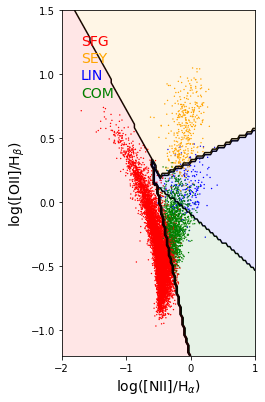

In [6]:
# COMPUTE AND PLOT THE DECISION BOUNDARIES

# > Creating a grid of predictions:
xlim = [-2,1]     # NII_diagnostic range
ylim = [-1.2,1.5] # OIII_diagnostic range

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 101), np.linspace(ylim[0], ylim[1], 101))
Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)
# Smooth the boundary:
#from scipy.ndimage import gaussian_filter
#Z = gaussian_filter(Z, 2)

# > Plotting

# Creating a colormap where:
#   red    <-> SFG
#   yellow <-> SEY
#   blue   <-> LIN
#   green  <-> COM
cmap = mpl.colors.ListedColormap(['red','orange','blue','green'])

fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0, left=0.1, right=0.95, wspace=0.4)

ax = fig.add_subplot(131)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:], s=2, lw=0, cmap=cmap, zorder=2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.set_xlabel('log([NII]/H$_{α})$', fontsize=14)
ax.set_ylabel('log([ΟII]/H$_{β})$', fontsize=14)
#
ax.imshow(Z, origin='lower', aspect='auto', cmap=cmap, zorder=2, alpha=0.1, extent=xlim + ylim)
ax.contour(xx, yy, Z, 4, colors='black')
# NOTE: there should be 4 contours corresponding to the 4 classes

# legend:
ax.text(0.1,0.90, "SFG", color='red',    transform=ax.transAxes, fontsize=14)
ax.text(0.1,0.85, "SEY", color='orange', transform=ax.transAxes, fontsize=14)
ax.text(0.1,0.80, "LIN", color='blue',   transform=ax.transAxes, fontsize=14)
ax.text(0.1,0.75, "COM", color='green',  transform=ax.transAxes, fontsize=14)


## Run SVM on all diagnostics alone (4D case, linear, 4 classes)

In [7]:
# RUNNING CLASSIFIER
from sklearn import metrics

kernel_to_use = "linear"
gamma_to_use = "auto"

clf = SVC(kernel=kernel_to_use, gamma=gamma_to_use, class_weight='balanced')
# NOTE: By setting X_train[:, :] we are using all diagnostics

# SUGGESTION: Use only <N_training> objects to speed up the exercise
#           Rn with the full training sample only when confident with the setup
N_training = 10000

clf.fit(X_train[0:N_training, :], y_train[0:N_training])
y_test_pred = clf.predict(X_test)

completeness, contamination = completeness_contamination(y_test_pred, y_test)

print("SVM with 4 diagnostics")
print("___________________________")
print("  completeness  | %-.2f [%%]" % (completeness*100))
print("  contamination | %-.2f [%%]" % (contamination*100))

print("\n")

print("Classification report for %s:\n%s\n"
      % (clf, metrics.classification_report(y_test, y_test_pred)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_test_pred))

SVM with 4 diagnostics
___________________________
  completeness  | 95.00 [%]
  contamination | 20.69 [%]


Classification report for SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       1.00      0.95      0.97     10820
          1       0.90      0.98      0.94       495
          2       0.80      0.99      0.88       204
          3       0.73      0.94      0.82      1561

avg / total       0.96      0.95      0.95     13080


Confusion matrix:
[[10260     6    15   539]
 [    0   486     4     5]
 [    0     1   201     2]
 [   21    49    31  1460]]


In [52]:
# COMPUTE AND PLOT THE DECISION BOUNDARIES

# > Creating a grid of predictions:
xlim = [-2,1]     # NII_diagnostic range
ylim = [-1.2,1.5] # OIII_diagnostic range
ilim = [-1.4,0.7] # SII_diagnostic range
jlim = [-2.2,0.0] # OI_diagnostic range

xx, yy, ii, jj = np.meshgrid(np.linspace(xlim[0], xlim[1], 30),
                     np.linspace(ylim[0], ylim[1], 30),
                     np.linspace(ilim[0], ilim[1], 30),
                     np.linspace(jlim[0], jlim[1], 30)
                    )
Z = clf.predict(np.c_[jj.ravel(),ii.ravel(),yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)
# Smooth the boundary:
#from scipy.ndimage import gaussian_filter
#Z = gaussian_filter(Z, 2)

Text(0.1,0.75,'COM')

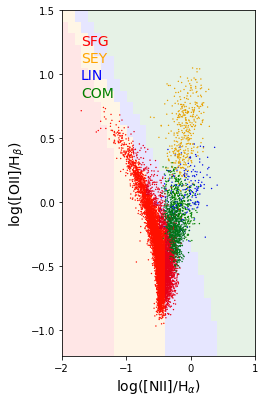

In [55]:
# > Plotting

# Creating a colormap where:
#   red    <-> SFG
#   yellow <-> SEY
#   blue   <-> LIN
#   green  <-> COM
cmap = mpl.colors.ListedColormap(['red','orange','blue','green'])

fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0, left=0.1, right=0.95, wspace=0.4)

ax = fig.add_subplot(131)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:], s=2, lw=0, cmap=cmap, zorder=2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.set_xlabel('log([NII]/H$_{α})$', fontsize=14)
ax.set_ylabel('log([ΟII]/H$_{β})$', fontsize=14)
#
# Projecting hypergrid over the first 2 diagnostics, using the average classification over the other dimensions:
Z_2D = np.mean(Z.reshape(len(Z),len(Z),len(Z),-1),axis=-1)
Z_2D = np.mean(Z_2D.reshape(len(Z),len(Z),-1),axis=-1)

ax.imshow(Z_2D, origin='lower', aspect='auto', cmap=cmap, zorder=2, alpha=0.1, extent=xlim + ylim)
#ax.contour(xx, yy, Z, 4, colors='black')
# NOTE: there should be 4 contours corresponding to the 4 classes

# legend:
ax.text(0.1,0.90, "SFG", color='red',    transform=ax.transAxes, fontsize=14)
ax.text(0.1,0.85, "SEY", color='orange', transform=ax.transAxes, fontsize=14)
ax.text(0.1,0.80, "LIN", color='blue',   transform=ax.transAxes, fontsize=14)
ax.text(0.1,0.75, "COM", color='green',  transform=ax.transAxes, fontsize=14)

### Loading and setting up the data

In [ ]:
# CREATING DATA STRUCTURE

# > Loading the emission line data from the MPA-JHU team's 'galSpec' table for the SDSS galaxies:

PATH_AGN_data = "data/sdss_lines.csv"

data = np.genfromtxt(PATH_AGN_data, delimiter=",")
# The data file is organized in 452 lines (i.e. different objects), and 15 columns

# To check file dimensions:
# print(data.shape)

ID             = data[:,0]  # object ID
H_BETA_FLUX    = data[:,1]  # flux of H_beta line
OIII_5007_FLUX = data[:,3]  # flux of OIII line at 5007 Amstrong
H_ALPHA_FLUX   = data[:,7]  # flux of H_alpha line
NII_6584_FLUX  = data[:,9]  # flux of NII line at 6584 Amstrong
SII_6717_FLUX  = data[:,12] # flux of SII line at 6717 Amstrong

labels = np.genfromtxt(PATH_AGN_data, delimiter=',', usecols=-2, dtype=str)
# reading labels from second column from the last

# > Replacing negative (bogus) fluxes with sample median:
#   NOTE: This will introduce some noise in the data, which is good for the sake of this exercise
OIII_5007_FLUX[OIII_5007_FLUX <= 0] = np.median(OIII_5007_FLUX)
NII_6584_FLUX[NII_6584_FLUX   <= 0] = np.median(NII_6584_FLUX)
SII_6717_FLUX[SII_6717_FLUX   <= 0] = np.median(SII_6717_FLUX)
H_BETA_FLUX[H_BETA_FLUX       <= 0] = np.median(H_BETA_FLUX)
H_ALPHA_FLUX[H_ALPHA_FLUX     <= 0] = np.median(H_ALPHA_FLUX)

# > Calculating diagnostic ratios:
OIII_diagnostic = np.log10(OIII_5007_FLUX / H_BETA_FLUX)  # OIII_5007 / H_beta
NII_diagnostic  = np.log10(NII_6584_FLUX  / H_ALPHA_FLUX) # NII_6584  / H_alpha
SII_diagnostic  = np.log10(SII_6717_FLUX  / H_ALPHA_FLUX) # SII_6717  / H_alpha

# > Organizing data in an analysis-ready fashion:
X = np.stack((OIII_diagnostic,NII_diagnostic,SII_diagnostic),axis=-1)
y = labels

In [ ]:
# SPLITTING SAMPLE IN TRAINING, VALIDATION, AND TEST

# Fractions of total sample to be re-distributed into training, validation, and test
train_frac = 0.80
valid_frac = 0.10
test_frac  = 0.10

(X_train, X_remain), (y_train, y_remain) = split_samples(X, y, [train_frac, (valid_frac+test_frac)], random_state=0)
# isolating first the training set ...

(X_valid, X_test), (y_valid, y_test)  = split_samples(X_remain, y_remain, [test_frac, valid_frac], random_state=0)
# ... and now repeting to split validation and training sets

n_train_AGN   = len([y for y in y_train if y == 'true'])
n_train_noAGN = len([y for y in y_train if y == 'false'])

n_valid_AGN   = len([y for y in y_valid if y == 'true'])
n_valid_noAGN = len([y for y in y_valid if y == 'false'])

n_test_AGN    = len([y for y in y_test if y == 'true'])
n_test_noAGN  = len([y for y in y_test if y == 'false'])


print("Sample Summary")
print("________________________________")
print("Total objects    | %-5s" % len(X))
print("-----------------|--------------")
print(" '-> Training    | %-5s" % len(X_train))
print("                 | " + str(X_train.shape))
print("      '-> AGN    | %-5s (%-.1f%%)" % (n_train_AGN,   (n_train_AGN/len(X_train)*100.)))
print("      '-> no AGN | %-5s (%-.1f%%)" % (n_train_noAGN, (n_train_noAGN/len(X_train)*100.)))
print("-----------------|--------------")
print(" '-> Validation  | %-5s" % len(X_valid))
print("                 | " + str(X_valid.shape))
print("      '-> AGN    | %-5s (%.1f%%)" % (n_valid_AGN,   (n_valid_AGN/len(X_valid)*100.)))
print("      '-> no AGN | %-5s (%.1f%%)" % (n_valid_noAGN, (n_valid_noAGN/len(X_valid)*100.)))
print("-----------------|--------------")
print(" '-> Test        | %-5s" % len(X_test))
print("                 | " + str(X_test.shape))
print("      '-> AGN    | %-5s (%.1f%%)" % (n_test_AGN,   (n_test_AGN/len(X_test)*100.)))
print("      '-> no AGN | %-5s (%.1f%%)" % (n_test_noAGN, (n_test_noAGN/len(X_test)*100.)))

#### Q: Is ithe sample shaped as expected?
It should be split as < N x M >, where N is the number of objects (with relative fractions given by the train, validation, and test fractions) and M the number of features we can use for the classification.

#### Q: Can we really use the validation/test sample?
No, the statistics are too low. That means for example that we cannot calibrate hyperparameters such as the $k$ in the KNN via cross-validation.